In [16]:
import nltk
import pandas as pd
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Bidirectional
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import numpy as np
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import Adamax 
from keras import regularizers
import seaborn as sb

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import chardet
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
# Load data from CSV file
data = pd.read_csv("/content/combined_vader_textblob_classified_data.csv", encoding="ISO-8859-1")
data

<ipython-input-13-15cc39dd2d5b>:2: DtypeWarning: Columns (1,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/combined_vader_textblob_classified_data.csv", encoding="ISO-8859-1")


,username,verified,followersCount,rawContent,date,replyCount,retweetCount,likeCount,url,hashtags,...,vader_preprocessing_text,vader_neg,vader_neu,vader_pos,vader_comp,class,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,final_class
0,G_F758,False,343,Hogwarts Legacy Flight the Good Flight (SILVER...,18/2/2023 12:47,0,0,1.0,https://twitter.com/G_F758/status/162692648616...,"['PlayStationTrophy', 'PS5Share', 'HogwartsLeg...",...,hogwarts legacy flight the good flight (silver...,0.000,0.674,0.326,0.4404,1,0.600000,0.700000,1,0.0
1,DeVinSimmons,False,421,Oh and how smooth getting on and off the broom...,16/2/2023 5:27,0,0,0.0,https://twitter.com/DeVinSimmons/status/162609...,['HogwartsLegacy'],...,oh and how smooth getting on and off the broom...,0.000,1.000,0.000,0.0000,0,0.500000,0.400000,1,0.0
2,cozzboz,False,117,Playing endless hours of #HogwartsLegacy got m...,16/2/2023 14:34,0,0,0.0,https://twitter.com/cozzboz/status/16262284309...,['HogwartsLegacy'],...,playing endless hours of got me in the mood f...,0.000,0.904,0.096,0.2023,1,0.575000,-0.062500,-1,0.0
3,Fantastic_4ork,False,486,Hey #AvalancheSoftware how about that #photomo...,15/2/2023 19:24,0,0,3.0,https://twitter.com/Fantastic_4ork/status/1625...,"['AvalancheSoftware', 'photomode', 'hogwartsle...",...,hey how about that for ? adegaa$?a*adegaaa ...,0.000,1.000,0.000,0.0000,0,0.000000,0.000000,0,0.0
4,jordan_sebas2,False,487,Hogwarts Legacy Flight the Good Flight (SILVER...,15/2/2023 19:57,0,0,0.0,https://twitter.com/jordan_sebas2/status/16259...,"['PlayStationTrophy', 'PS5Share', 'HogwartsLeg...",...,hogwarts legacy flight the good flight (silver...,0.000,0.530,0.470,0.7964,1,0.533333,0.266667,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79545,Abfun77,False,382,Video of ELDEN RING: All Quests in Order + Mis...,22/2/2023 0:17,0,7,79.0,https://twitter.com/Abfun77/status/16281871857...,"['ELDENRING', 'ELDEN_RING', 'guide', 'gaming',...",...,video of elden ring: all quests in order + mis...,0.000,1.000,0.000,0.0000,0,0.767857,0.142857,1,0.0
79546,Vivern96,False,7,Red Wolf of Radagon RL1 NoHit #ELDEN_RING #ELD...,16/6/2022 14:29,0,0,1.0,https://twitter.com/Vivern96/status/1537442134...,"['ELDEN_RING', 'ELDENRING', 'gaming', 'game']",...,red wolf of radagon rl1 nohit,0.000,1.000,0.000,0.0000,0,0.000000,0.000000,0,0.0
79547,EllieCupcakes,False,263,Fanart of Miruku with her Apostle (Slim) and M...,3/3/2023 21:01,1,7,32.0,https://twitter.com/EllieCupcakes/status/16317...,"['EldenRing', 'EldenRingArt']",...,fanart of miruku with her apostle (slim) and m...,0.000,1.000,0.000,0.0000,0,0.000000,0.000000,0,0.0
79548,Pinknotess,False,0,This comic is definitely worth reading! Come c...,19/3/2023 3:42,0,0,0.0,https://twitter.com/Pinknotess/status/16372984...,"['EldenRing', 'illusrtationart', 'Romance']",...,this comic is definitely worth reading! come c...,0.000,0.607,0.393,0.6351,1,0.300000,0.359375,1,1.0


In [14]:
print("Shape of data =>",data.shape)

Shape of data => (79550, 23)


In [15]:
def featureEngineering(tweet):
    # Lower case tweet
    tweetMod = tweet.lower()
    # Replace URLs with a space in the message
    tweetMod = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweetMod)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    tweetMod = re.sub('\$[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    tweetMod = re.sub('\@[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace everything not a letter or apostrophe with a space
    tweetMod = re.sub('[^a-zA-Z\']', ' ', tweetMod)
    # Remove single letter words
    tweetMod = ' '.join([w for w in tweetMod.split() if len(w) > 1])

    return tweetMod


# Process for all tweets
data['modTweet'] = [featureEngineering(tweet) for tweet in data['vader_preprocessing_text']]

def lemmatizeTweet(tweet):
    words = [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return " ".join(lemmatized)

data['lemmatizedText'] = data["modTweet"].apply(lambda x:lemmatizeTweet(x))

In [17]:
data

,username,verified,followersCount,rawContent,date,replyCount,retweetCount,likeCount,url,hashtags,...,vader_neu,vader_pos,vader_comp,class,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,final_class,modTweet,lemmatizedText
0,G_F758,False,343,Hogwarts Legacy Flight the Good Flight (SILVER...,18/2/2023 12:47,0,0,1.0,https://twitter.com/G_F758/status/162692648616...,"['PlayStationTrophy', 'PS5Share', 'HogwartsLeg...",...,0.674,0.326,0.4404,1,0.600000,0.700000,1,0.0,hogwarts legacy flight the good flight silver,hogwarts legacy flight good flight silver
1,DeVinSimmons,False,421,Oh and how smooth getting on and off the broom...,16/2/2023 5:27,0,0,0.0,https://twitter.com/DeVinSimmons/status/162609...,['HogwartsLegacy'],...,1.000,0.000,0.0000,0,0.500000,0.400000,1,0.0,oh and how smooth getting on and off the broom is,oh smooth get broom
2,cozzboz,False,117,Playing endless hours of #HogwartsLegacy got m...,16/2/2023 14:34,0,0,0.0,https://twitter.com/cozzboz/status/16262284309...,['HogwartsLegacy'],...,0.904,0.096,0.2023,1,0.575000,-0.062500,-1,0.0,playing endless hours of got me in the mood fo...,play endless hour get mood hogwarts life curre...
3,Fantastic_4ork,False,486,Hey #AvalancheSoftware how about that #photomo...,15/2/2023 19:24,0,0,3.0,https://twitter.com/Fantastic_4ork/status/1625...,"['AvalancheSoftware', 'photomode', 'hogwartsle...",...,1.000,0.000,0.0000,0,0.000000,0.000000,0,0.0,hey how about that for adegaa adegaaa ac aaac aaa,hey adegaa adegaaa ac aaac aaa
4,jordan_sebas2,False,487,Hogwarts Legacy Flight the Good Flight (SILVER...,15/2/2023 19:57,0,0,0.0,https://twitter.com/jordan_sebas2/status/16259...,"['PlayStationTrophy', 'PS5Share', 'HogwartsLeg...",...,0.530,0.470,0.7964,1,0.533333,0.266667,1,0.0,hogwarts legacy flight the good flight silver ...,hogwarts legacy flight good flight silver love...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79545,Abfun77,False,382,Video of ELDEN RING: All Quests in Order + Mis...,22/2/2023 0:17,0,7,79.0,https://twitter.com/Abfun77/status/16281871857...,"['ELDENRING', 'ELDEN_RING', 'guide', 'gaming',...",...,1.000,0.000,0.0000,0,0.767857,0.142857,1,0.0,video of elden ring all quests in order missab...,video elden ring quest order missable content ...
79546,Vivern96,False,7,Red Wolf of Radagon RL1 NoHit #ELDEN_RING #ELD...,16/6/2022 14:29,0,0,1.0,https://twitter.com/Vivern96/status/1537442134...,"['ELDEN_RING', 'ELDENRING', 'gaming', 'game']",...,1.000,0.000,0.0000,0,0.000000,0.000000,0,0.0,red wolf of radagon rl nohit,red wolf radagon rl nohit
79547,EllieCupcakes,False,263,Fanart of Miruku with her Apostle (Slim) and M...,3/3/2023 21:01,1,7,32.0,https://twitter.com/EllieCupcakes/status/16317...,"['EldenRing', 'EldenRingArt']",...,1.000,0.000,0.0000,0,0.000000,0.000000,0,0.0,fanart of miruku with her apostle slim and mir...,fanart miruku apostle slim miruku dance ellie ...
79548,Pinknotess,False,0,This comic is definitely worth reading! Come c...,19/3/2023 3:42,0,0,0.0,https://twitter.com/Pinknotess/status/16372984...,"['EldenRing', 'illusrtationart', 'Romance']",...,0.607,0.393,0.6351,1,0.300000,0.359375,1,1.0,this comic is definitely worth reading come ch...,comic definitely worth read come check


In [18]:
GOW = data.loc[data['game'] == 'GOW']
HGL = data.loc[data['game'] == 'HGL']
Stardew = data.loc[data['game'] == 'Stardew']
Cyberpunk = data.loc[data['game'] == 'Cyberpunk']
MHW = data.loc[data['game'] == 'MHW']
ELR = data.loc[data['game'] == 'ELR']

In [19]:
# Create an empty set to store unique words
unique_words = set()

# Loop over each row in the 'processed' column
for row in data['lemmatizedText']:
    # Split the row into individual words
    words = row.split()
    # Add each word to the set of unique words
    unique_words.update(words)

# Print the total number of unique words
print(len(unique_words))

35210


In [20]:
# Calculate the total number of words in the 'rawContent' column
total_words = data['lemmatizedText'].str.split().str.len().sum()

print(f'Total number of words: {total_words}')

Total number of words: 667585


GOW          20623
HGL          17128
Cyberpunk    14595
ELR           9617
MHW           8957
Stardew       8630
Name: game, dtype: int64


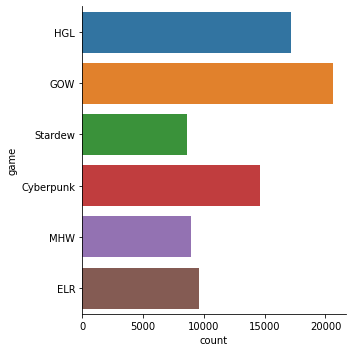

In [21]:
print(data["game"].value_counts())
plot = sb.catplot(y = "game", data = data, kind = "count")
plot.savefig("processed_game_count.png", dpi=300, bbox_inches='tight')

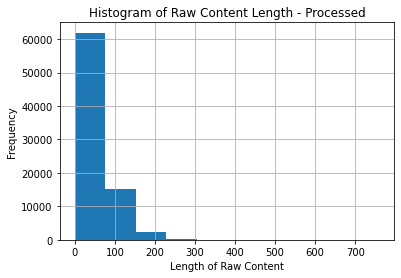

In [27]:
# Create a histogram of the length of the "rawContent" column in data
data['lemmatizedText'].str.len().hist()
plt.title("Histogram of Raw Content Length - Processed")
plt.xlabel("Length of Raw Content")
plt.ylabel("Frequency")
plt.savefig("processed_length_hist.png", dpi=300, bbox_inches='tight')

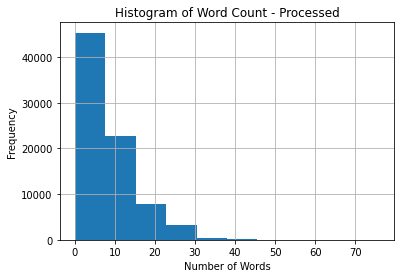

In [28]:
# Word count
data['lemmatizedText'].str.split().map(lambda x: len(x)).hist()
plt.title("Histogram of Word Count - Processed")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.savefig("processed_word_count_hist.png", dpi=300, bbox_inches='tight')

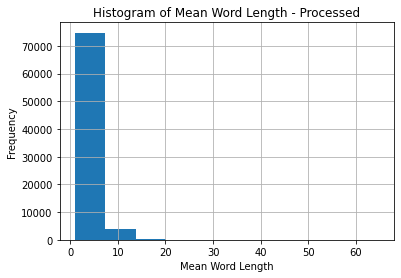

In [29]:
# Word Length
data['lemmatizedText'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.title("Histogram of Mean Word Length - Processed")
plt.xlabel("Mean Word Length")
plt.ylabel("Frequency")
plt.savefig("processed_mean_word_length_hist.png", dpi=300, bbox_inches='tight')

In [30]:
stop=set(stopwords.words('english'))

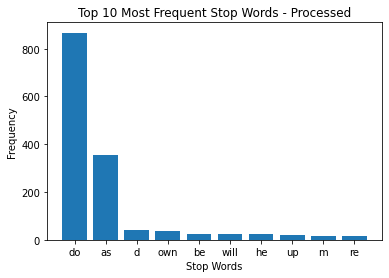

In [31]:
# Plot the occurances of the most common stopwords in the dataset - create the corpus
corpus = []
check = data['lemmatizedText'].str.split()
check = check.values.tolist()
corpus = [word for i in check for word in i]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10] 
x, y = zip(*top)
plt.bar(x, y)
plt.title("Top 10 Most Frequent Stop Words - Processed")
plt.xlabel("Stop Words")
plt.ylabel("Frequency")
plt.savefig("processed_stop_words_bar.png", dpi=300, bbox_inches='tight')

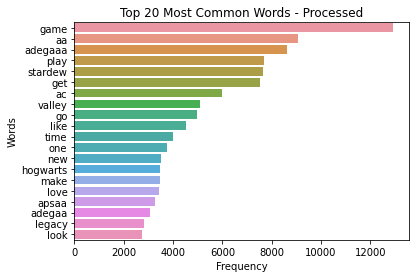

In [33]:
# Common words plot
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word, count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sb.barplot(x=y, y=x)
plt.title("Top 20 Most Common Words - Processed")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.savefig("processed_top_20_common_words_bar.png", dpi=300, bbox_inches='tight')

In [34]:
def plot_top_ngrams_barchart(text, n=2, output_filename=None):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_ngrams = _get_top_ngram(text, n)[:10]
    x, y = map(list, zip(*top_n_ngrams))
    sb.barplot(x=y, y=x)
    plt.title(f"Top {n}-grams")
    plt.xlabel("Frequency")
    plt.ylabel(f"{n}-grams")
    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')

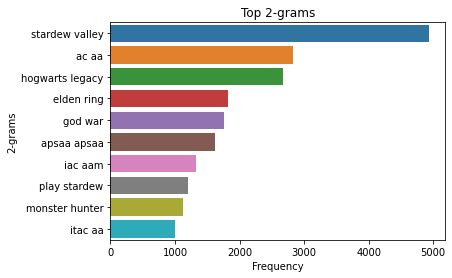

In [35]:
plot_top_ngrams_barchart(data['lemmatizedText'],2)

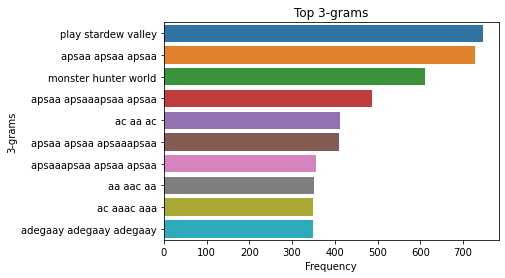

In [36]:
plot_top_ngrams_barchart(data['lemmatizedText'],3)

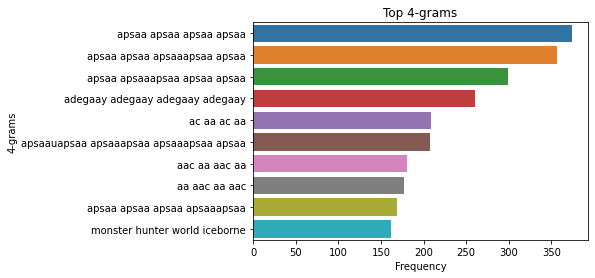

In [37]:
plot_top_ngrams_barchart(data['lemmatizedText'],4)

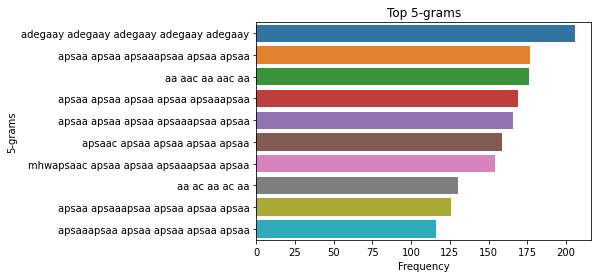

In [38]:
plot_top_ngrams_barchart(data['lemmatizedText'],5)

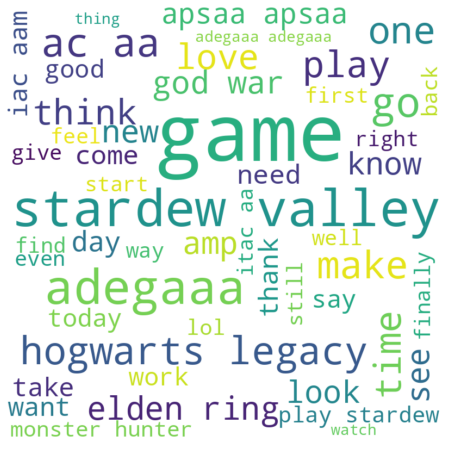

In [39]:
# Generate wordcloud from tweets - 50
wordcloud = WordCloud(width=800, height=800, background_color="white", max_words=50, contour_width=3, contour_color="steelblue")
wordcloud.generate(" ".join(data["lemmatizedText"]))

# Display wordcloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Save wordcloud as PNG file
plt.savefig("processed_wordcloud_50.png", dpi=300)

plt.show()

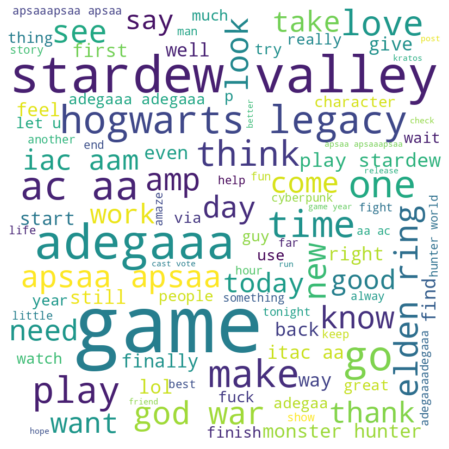

In [40]:
# Generate wordcloud from tweets - 100
wordcloud = WordCloud(width=800, height=800, background_color="white", max_words=100, contour_width=3, contour_color="steelblue")
wordcloud.generate(" ".join(data["lemmatizedText"]))

# Display wordcloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Save wordcloud as PNG file
plt.savefig("processed_wordcloud_100.png", dpi=300)

plt.show()

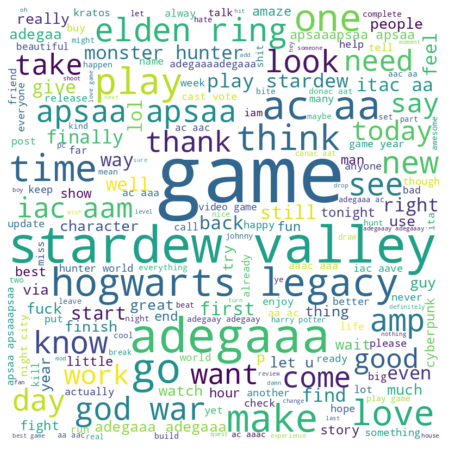

In [41]:
# Generate wordcloud from tweets - 200
wordcloud = WordCloud(width=800, height=800, background_color="white", max_words=200, contour_width=3, contour_color="steelblue")
wordcloud.generate(" ".join(data["lemmatizedText"]))

# Display wordcloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Save wordcloud as PNG file
plt.savefig("processed_wordcloud_200.png", dpi=300)

plt.show()

 0.0    29891
 1.0    27611
-1.0    22048
Name: final_class, dtype: int64


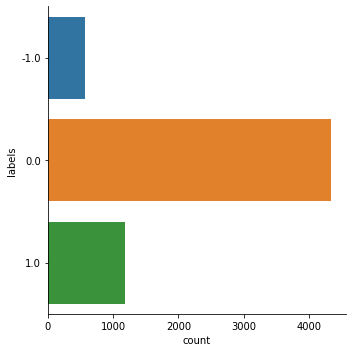

In [43]:
# Print value counts of labels
print(data["final_class"].value_counts())

# Create countplot using Seaborn
fig = sb.catplot(y="labels", data=data, kind="count")

# Save countplot as PNG file
fig.savefig("processed_labels_countplot.png", dpi=300)

# Show countplot
plt.show()